In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('..')

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    cross_val_sklearn,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.mlexplain import *
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [3]:
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )

### Data loading

In [4]:
df = get_dataset(
    labels_file="../data/class_vector_train_ref.mat",
    params_file="../data/training_set_ref.mat",
    names_file="../data/paremeterNames.mat",
)

print(f"***Dataset shape: {df.shape}\n")

get_value_counts(df)

***Dataset shape: (200000, 259)



,percentage,absolute
0,0.5287,105746.0
1,0.4713,94254.0


In [6]:
df.describe()

,BIO@atp_c,BIO@pyr_c,BIO@nad_c,BIO@g6p_c,BIO@oaa_c,BIO@f6p_c,BIO@nadph_c,BIO@nh4_c,BIO@o2_c,BIO@r5p_c,...,D_LAC@feri_m,D_LAC@lac_m,SUCCt2r@suc_c,MALt2r@mal_c,CITt2m@mal_c,CITt2m@cit_m,CITt2m@mal_m,CITt2m@cit_c,PFK@amp_c,label
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.489436,0.497966,0.499534,0.496204,0.506455,0.502474,0.496876,0.490956,0.514771,0.516237,...,0.499362,0.499051,0.498496,0.499608,0.502218,0.495622,0.495375,0.512033,0.507610,0.471270
std,0.287882,0.288132,0.288272,0.288298,0.287783,0.288211,0.287607,0.287219,0.288335,0.287566,...,0.287642,0.288348,0.287531,0.287657,0.288134,0.286911,0.286941,0.287787,0.285128,0.499175
min,0.001004,0.001005,0.001004,0.001011,0.001002,0.001011,0.001003,0.001004,0.001002,0.001000,...,0.001003,0.001011,0.001001,0.001000,0.001004,0.001005,0.001003,0.001012,0.001001,0.000000
25%,0.239085,0.248198,0.249185,0.246103,0.258372,0.253407,0.248500,0.241184,0.267980,0.270095,...,0.249469,0.248732,0.249821,0.251361,0.253369,0.247804,0.246431,0.264410,0.264061,0.000000
50%,0.483135,0.497502,0.499087,0.494300,0.509272,0.502726,0.495263,0.487530,0.522684,0.523729,...,0.499422,0.497849,0.497525,0.498985,0.504017,0.493972,0.493953,0.518108,0.508746,0.000000
75%,0.737686,0.747344,0.749426,0.745611,0.757146,0.753230,0.744840,0.738302,0.766902,0.767502,...,0.747530,0.748604,0.746582,0.748161,0.752102,0.742839,0.742725,0.761667,0.754043,1.000000
max,0.998979,0.998993,0.998988,0.998980,0.998995,0.998999,0.998999,0.998991,0.998997,0.998999,...,0.998999,0.998994,0.998981,0.998998,0.998990,0.998997,0.998990,0.999000,0.999000,1.000000


### Train - Test data split

In [5]:
X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=1000, target="label")

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print('Training set value counts:')
get_value_counts(train_df)

print('Test set value counts:')
get_value_counts(test_df)

Traininig set shape: (1000, 258)
Test set shape: (199000, 258)


Training set value counts:


,percentage,absolute
0,0.529,529.0
1,0.471,471.0


Test set value counts:


,percentage,absolute
0,0.5287,105217.0
1,0.4713,93783.0


# Feature Selection

In [10]:
model_name = 'xgboost_model_FCC_1000.pkl'
try:
    with open(f'../models/{model_name}', 'rb') as f:
        # Pickle load file
        xgb_model = pickle.load(f)
        print('Model loaded successfully\n')
except FileNotFoundError:
    xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)
    # Pickle save model
    with open(f'../models/{model_name}', 'wb') as f:
        pickle.dump(xgb_model, f)

Model loaded successfully



In [11]:
print('Cross validation:')
cross_val_sklearn(xgb_model, X_train, y_train)
print()
print('Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

Cross validation:
Accuracy: 0.615
Precision: 0.6082
Recall: 0.535
F1: 0.5668
ROC AUC: 0.6392
MCC: 0.2262

Evaluation on test set:
Accuracy: 0.6072
Precision: 0.5883
Recall: 0.5548
F1 score: 0.5711
ROC AUC score: 0.6043
MCC: 0.2096


In [17]:
# Get shap values
shap_values_df = get_shap_values(xgb_model, X_train)

In [22]:
# Select features with SHAP values > 0.1
threshold = 0.01
selected_features = (np.abs(shap_values_df).mean()) > threshold
selected_features = selected_features[selected_features.values].index.values
print(f'Number of selected features: {len(selected_features)}')

X_train = X_train[selected_features]
X_test = X_test[selected_features]

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

Number of selected features: 207


In [ ]:
# Retrain model with selected features
model_name = 'xgboost_model_FCC_1000_selected.pkl'
try:
    with open(f'../models/{model_name}', 'rb') as f:
        # Pickle load file
        xgb_model = pickle.load(f)
        print('Model loaded successfully\n')
except FileNotFoundError:
    xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)
    # Pickle save model
    with open(f'../models/{model_name}', 'wb') as f:
        pickle.dump(xgb_model, f)

In [24]:
print('Cross validation:')
cross_val_sklearn(xgb_model, X_train, y_train)
print()
print('Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

Cross validation:
Accuracy: 0.633
Precision: 0.6177
Recall: 0.5924
F1: 0.604
ROC AUC: 0.648
MCC: 0.2633

Evaluation on test set:
Accuracy: 0.6085
Precision: 0.5972
Recall: 0.5201
F1 score: 0.5560
ROC AUC score: 0.6037
MCC: 0.2105


Using ONLY the SHAP-based selected features, the performance of XGBoost increased!

# Machine Learning

### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)

In [26]:
# Cross-validated performance
cross_val_sklearn(cart_model, X_train, y_train)

Accuracy: 0.578
Precision: 0.5535
Recall: 0.586
F1: 0.5593
ROC AUC: 0.5944
MCC: 0.1638


In [27]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(cart_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(cart_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.6420
Precision: 0.7868
Recall: 0.3291
F1 score: 0.4641
ROC AUC score: 0.6248
MCC: 0.3134

*** Evaluation on test set:
Accuracy: 0.5521
Precision: 0.5622
Recall: 0.2239
F1 score: 0.3202
ROC AUC score: 0.5343
MCC: 0.0876


In [28]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 8


['if (XRI@nadh_c <= 0.56) and (NDH@q_m > 0.129) and (TPI@t3p_c <= 0.84) then class: 0 (proba: 51.03%) | based on 439 samples',
 'if (XRI@nadh_c > 0.56) and (XRI@nad_c <= 0.717) and (ATPM@atp_c > 0.494) then class: 0 (proba: 64.43%) | based on 149 samples',
 'if (XRI@nadh_c > 0.56) and (XRI@nad_c <= 0.717) and (ATPM@atp_c <= 0.494) then class: 0 (proba: 85.51%) | based on 138 samples',
 'if (XRI@nadh_c <= 0.56) and (NDH@q_m > 0.129) and (TPI@t3p_c > 0.84) then class: 1 (proba: 72.97%) | based on 74 samples',
 'if (XRI@nadh_c <= 0.56) and (NDH@q_m <= 0.129) and (IDH@akg_m <= 0.829) then class: 1 (proba: 85.14%) | based on 74 samples',
 'if (XRI@nadh_c > 0.56) and (XRI@nad_c > 0.717) and (TKL1@r5p_c <= 0.629) then class: 0 (proba: 62.12%) | based on 66 samples',
 'if (XRI@nadh_c > 0.56) and (XRI@nad_c > 0.717) and (TKL1@r5p_c > 0.629) then class: 1 (proba: 77.55%) | based on 49 samples',
 'if (XRI@nadh_c <= 0.56) and (NDH@q_m <= 0.129) and (IDH@akg_m > 0.829) then class: 0 (proba: 72.73%)

In [29]:
rule = ruler.get_rule_constraints(5)
print(rule)
sampled_df = sample_from_df(train_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c>0.56', 'XRI@nad_c>0.717', 'TKL1@r5p_c<=0.629']
Number of parameter sets following the rule: 66


,percentage,absolute
0,0.6212,41.0
1,0.3788,25.0


In [17]:
rule = ruler.get_rule_constraints(5)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m>0.582', 'ASN@atp_m<=0.708', 'TPI@t3p_c>0.479', 'LSC@coa_m<=0.911']
Number of parameter sets following the rule: 12465


,percentage,absolute
1,0.7135,8894.0
0,0.2865,3571.0


##### Skope - Rules

In [18]:
with open('../models/skope_rules_clf.pkl', 'rb') as f:
    skope_rules_clf = pickle.load(f)
    
skope_rules_clf.fit(X_train, y_train)

SkopeRules(feature_names=['XRI@nadh_c', 'NDR@nadp_c', 'ASN@pi_m', 'XRI@nad_c',
                          'XDH@xlt_c', 'NH4t@nh4_c', 'TPI@t3p_c', 'XK@xyll_c',
                          'ADK@adp_c', 'TDH@t3p_c', 'PGK@dpg_c', 'GND1@6pgl_c',
                          'PGI@f6p_c', 'ZWF@nadp_c', 'XDH@nadh_c', 'XK@adp_c',
                          'GPD1@dhap_c', 'XK@x5p_c', 'ZWF@6pgl_c', 'XDH@nad_c',
                          'TKL2@e4p_c', 'BIO@so4_c', 'GLYCt@glyc_c',
                          'TPI@dhap_c', 'LSC@suc_m', 'PDA@nadh_m', 'ADH1@nad_c',
                          'HXK@atp_c', 'XDH@xyll_c', 'LSC@succoa_m', ...],
           n_jobs=-1, precision_min=0.1, random_state=42, recall_min=0.2)

In [20]:
# # Cross-validated performance
# print('Accuracy = ', cross_val_sklearn(skope_rules_clf, X_train, y_train, scoring='accuracy'))
# print('Precision = ', cross_val_sklearn(skope_rules_clf, X_train, y_train, scoring='precision'))
# print('Recall = ', cross_val_sklearn(skope_rules_clf, X_train, y_train, scoring='recall'))
# print('F1 = ', cross_val_sklearn(skope_rules_clf, X_train, y_train, scoring='f1'))
# print('ROC-AUC = ', cross_val_sklearn(skope_rules_clf, X_train, y_train, scoring='roc_auc'))
# print('MCC = ', cross_val_sklearn(skope_rules_clf, X_train, y_train, scoring='matthews_corrcoef'))

In [21]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(skope_rules_clf, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(skope_rules_clf, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.5756
Precision: 0.5391
Recall: 0.6868
F1 score: 0.6040
ROC AUC score: 0.5816
MCC: 0.1664

*** Evaluation on test set:
Accuracy: 0.5697
Precision: 0.5341
Recall: 0.6796
F1 score: 0.5981
ROC AUC score: 0.5756
MCC: 0.1541


In [22]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_[:10]:
    print(i)
    

*** Number of rules 14
('XRI@nadh_c <= 0.5265026688575745 and ASN@pi_m <= 0.5828556716442108 and GPD2@g3p_c <= 0.9556194841861725', (0.4929145921103026, 0.3438418380977825, 2))
('XRI@nadh_c <= 0.5968270897865295 and ASN@pi_m <= 0.6520956158638 and TPI@t3p_c > 0.3049936443567276', (0.520605550883095, 0.32812085873310365, 2))
('XRI@nadh_c <= 0.5795927345752716 and ASN@pi_m > 0.5425607562065125 and XDH@xlt_c <= 0.8067740201950073', (0.6515426497277677, 0.2832719621251973, 2))
('XRI@nadh_c <= 0.5807736217975616 and ASN@pi_m <= 0.9248725473880768 and ASN@pi_m > 0.542642205953598', (0.6068376068376068, 0.2802631578947368, 2))
('XRI@nadh_c <= 0.5265026688575745 and ASN@pi_m > 0.5828556716442108 and NH4t@nh4_c > 0.1436070129275322', (0.6623728813559322, 0.2610205717339033, 2))
('XRI@nadh_c <= 0.5288165509700775 and ASN@pi_m <= 0.5138014554977417 and GPD2@g3p_c <= 0.9533834457397461', (0.47801724137931034, 0.29604911906033105, 2))
('XRI@nadh_c <= 0.5139082670211792 and ASN@pi_m <= 0.51387384533

In [30]:
rule = skope_rules_clf.rules_[1][0]
print(rule)
sampled_df = sample_from_df(test_df, rule, skope_rules=True)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

XRI@nadh_c <= 0.5968270897865295 and ASN@pi_m <= 0.6520956158638 and TPI@t3p_c > 0.3049936443567276
Number of parameter sets following the rule: 56057


,percentage,absolute
1,0.5103,28606.0
0,0.4897,27451.0


##### XGBoost

In [ ]:
with open('../models/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
    
xgb_model.fit(X_train, y_train)

In [35]:
# Cross-validated performance
print('Accuracy = ', cross_val_sklearn(cart_model, X_train, y_train, scoring='accuracy'))
print('Precision = ', cross_val_sklearn(cart_model, X_train, y_train, scoring='precision'))
print('Recall = ', cross_val_sklearn(cart_model, X_train, y_train, scoring='recall'))
print('F1 = ', cross_val_sklearn(cart_model, X_train, y_train, scoring='f1'))
print('ROC-AUC = ', cross_val_sklearn(cart_model, X_train, y_train, scoring='roc_auc'))
print('MCC = ', cross_val_sklearn(cart_model, X_train, y_train, scoring='matthews_corrcoef'))

Accuracy =  0.6008
Precision =  0.5826
Recall =  0.537
F1 =  0.5587
ROC-AUC =  0.6308
MCC =  0.1961


In [36]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_sklearn(xgb_model, X_train, y_train)

print()

print('*** Evaluation on test set:')
evaluate_sklearn(xgb_model, X_test, y_test)

*** Evaluation on training set:
Accuracy: 0.8599
Precision: 0.8673
Recall: 0.8296
F1 score: 0.8481
ROC AUC score: 0.8583
MCC: 0.7188

*** Evaluation on test set:
Accuracy: 0.6806
Precision: 0.6727
Recall: 0.6275
F1 score: 0.6493
ROC AUC score: 0.6777
MCC: 0.3574


In [37]:
with open('../models/xgb2tree.pkl', 'rb') as f:
    xgb2tree = pickle.load(f)

In [38]:
evaluate_sklearn(xgb2tree, X_train, y_train)

print()

evaluate_sklearn(xgb2tree, X_test, y_test)

Accuracy: 0.6604
Precision: 0.6545
Recall: 0.5918
F1 score: 0.6216
ROC AUC score: 0.6567
MCC: 0.3163

Accuracy: 0.6147
Precision: 0.5994
Recall: 0.5500
F1 score: 0.5736
ROC AUC score: 0.6112
MCC: 0.2240


In [39]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules[:10]

['if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.887) and (ASN@pi_m <= 0.71) and (GND1@6pgl_c <= 0.956) and (XRI@nad_c <= 0.763) and (ADK@adp_c > 0.466) then class: 0 (proba: 88.95%) | based on 1,539 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.515) and (ASN@pi_m > 0.649) and (NH4t@nh4_c > 0.118) and (ASN@atp_m <= 0.832) and (TDH@dpg_c > 0.057) then class: 1 (proba: 84.11%) | based on 1,152 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.887) and (ASN@pi_m <= 0.71) and (GND1@6pgl_c <= 0.956) and (XRI@nad_c <= 0.763) and (ADK@adp_c <= 0.466) then class: 0 (proba: 77.08%) | based on 842 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.515) and (XRI@nad_c <= 0.566) and (ADK@adp_c > 0.642) and (GND1@6pgl_c <= 0.942) and (PGK@dpg_c <= 0.933) then class: 0 (proba: 77.16%) | based on 718 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.515) and (XRI@nad_c > 0.566) and (TPI@t3p_c > 0.361) and (GPD2@g3p_c <= 0.956) and (XDH@nadh_c <= 0.576) then class: 1 (proba: 76.

In [47]:
rule = ruler.get_rule_constraints(4)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m<=0.515', 'XRI@nad_c>0.566', 'TPI@t3p_c>0.361', 'GPD2@g3p_c<=0.956', 'XDH@nadh_c<=0.576']
Number of parameter sets following the rule: 9096


,percentage,absolute
1,0.5995,5453.0
0,0.4005,3643.0


### Neural Network

In [48]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ANNClassifier(input_dim=X_train.shape[1], hidden_dim=2048,
                    output_dim=1, hidden_layers=4).to(device)

net = train_ann(net, X_train, y_train, num_epochs=1000, learning_rate=0.001, batch_size=2048)

Epoch 0, Loss: 0.692275
Epoch 10, Loss: 0.573255
Epoch 20, Loss: 0.482714
Epoch 30, Loss: 0.275603
Epoch 40, Loss: 0.011517
Epoch 50, Loss: 0.000098
Epoch 60, Loss: 0.000033
Epoch 70, Loss: 0.000021
Epoch 80, Loss: 0.000011
Epoch 90, Loss: 0.000009
Epoch 100, Loss: 0.000006
Epoch 110, Loss: 0.000005
Epoch 120, Loss: 0.000004
Epoch 130, Loss: 0.000003
Epoch 140, Loss: 0.000003
Epoch 150, Loss: 0.000002
Epoch 160, Loss: 0.000002
Epoch 170, Loss: 0.000002
Epoch 180, Loss: 0.000002
Epoch 190, Loss: 0.000001
Epoch 200, Loss: 0.000001
Epoch 210, Loss: 0.000001
Epoch 220, Loss: 0.000001
Epoch 230, Loss: 0.000001
Epoch 240, Loss: 0.000001
Epoch 250, Loss: 0.000001
Epoch 260, Loss: 0.000000
Epoch 270, Loss: 0.000000
Epoch 280, Loss: 0.000000
Epoch 290, Loss: 0.000000
Epoch 300, Loss: 0.000000
Epoch 310, Loss: 0.000000
Epoch 320, Loss: 0.000000
Epoch 330, Loss: 0.000000
Epoch 340, Loss: 0.000000
Early stopping on epoch 345


In [49]:
# Evaluate model
print('*** Evaluation on training set:')
evaluate_ann(net, X_train, y_train)
print()

print('*** Evaluation on test set:')
evaluate_ann(net, X_test, y_test)

*** Evaluation on training set:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1: 1.0000
MCC: 1.0000

*** Evaluation on test set:
Accuracy: 0.6325
Precision: 0.6112
Recall: 0.6054
F1: 0.6082
MCC: 0.2622


In [50]:
ann_preds = get_predictions(net, X_train)
ann2tree = ml2tree(X_train, ann_preds, scoring='precision', n_trials=100)

In [51]:
evaluate_sklearn(ann2tree, X_train, y_train)

print()

evaluate_sklearn(ann2tree, X_test, y_test)

Accuracy: 0.5993
Precision: 0.6355
Recall: 0.3514
F1 score: 0.4525
ROC AUC score: 0.5858
MCC: 0.1952

Accuracy: 0.5893
Precision: 0.6143
Recall: 0.3452
F1 score: 0.4421
ROC AUC score: 0.5760
MCC: 0.1720


In [52]:
ruler = TreeRuler(df=train_df, tree_clf=ann2tree, target="label")
ruler.get_rules()
ruler.rules

['if (XRI@nadh_c > 0.529) and (XRI@nad_c <= 0.888) then class: 0 (proba: 64.6%) | based on 3,997 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m <= 0.582) then class: 0 (proba: 51.66%) | based on 3,397 samples',
 'if (XRI@nadh_c <= 0.529) and (ASN@pi_m > 0.582) then class: 1 (proba: 64.5%) | based on 2,110 samples',
 'if (XRI@nadh_c > 0.529) and (XRI@nad_c > 0.888) then class: 1 (proba: 59.48%) | based on 496 samples']

In [57]:
rule = ruler.get_rule_constraints(2)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['XRI@nadh_c<=0.529', 'ASN@pi_m>0.582']
Number of parameter sets following the rule: 39977


,percentage,absolute
1,0.6356,25411.0
0,0.3644,14566.0


### Exlainable Machine Learning

In [58]:
# xgb.plot_importance(xgb_model, importance_type='gain')
# plt.show()

2024-10-02 14:49:45.101881: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-02 14:49:45.117638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 14:49:45.134451: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 14:49:45.139192: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 14:49:45.152937: I tensorflow/core/platform/cpu_feature_guar

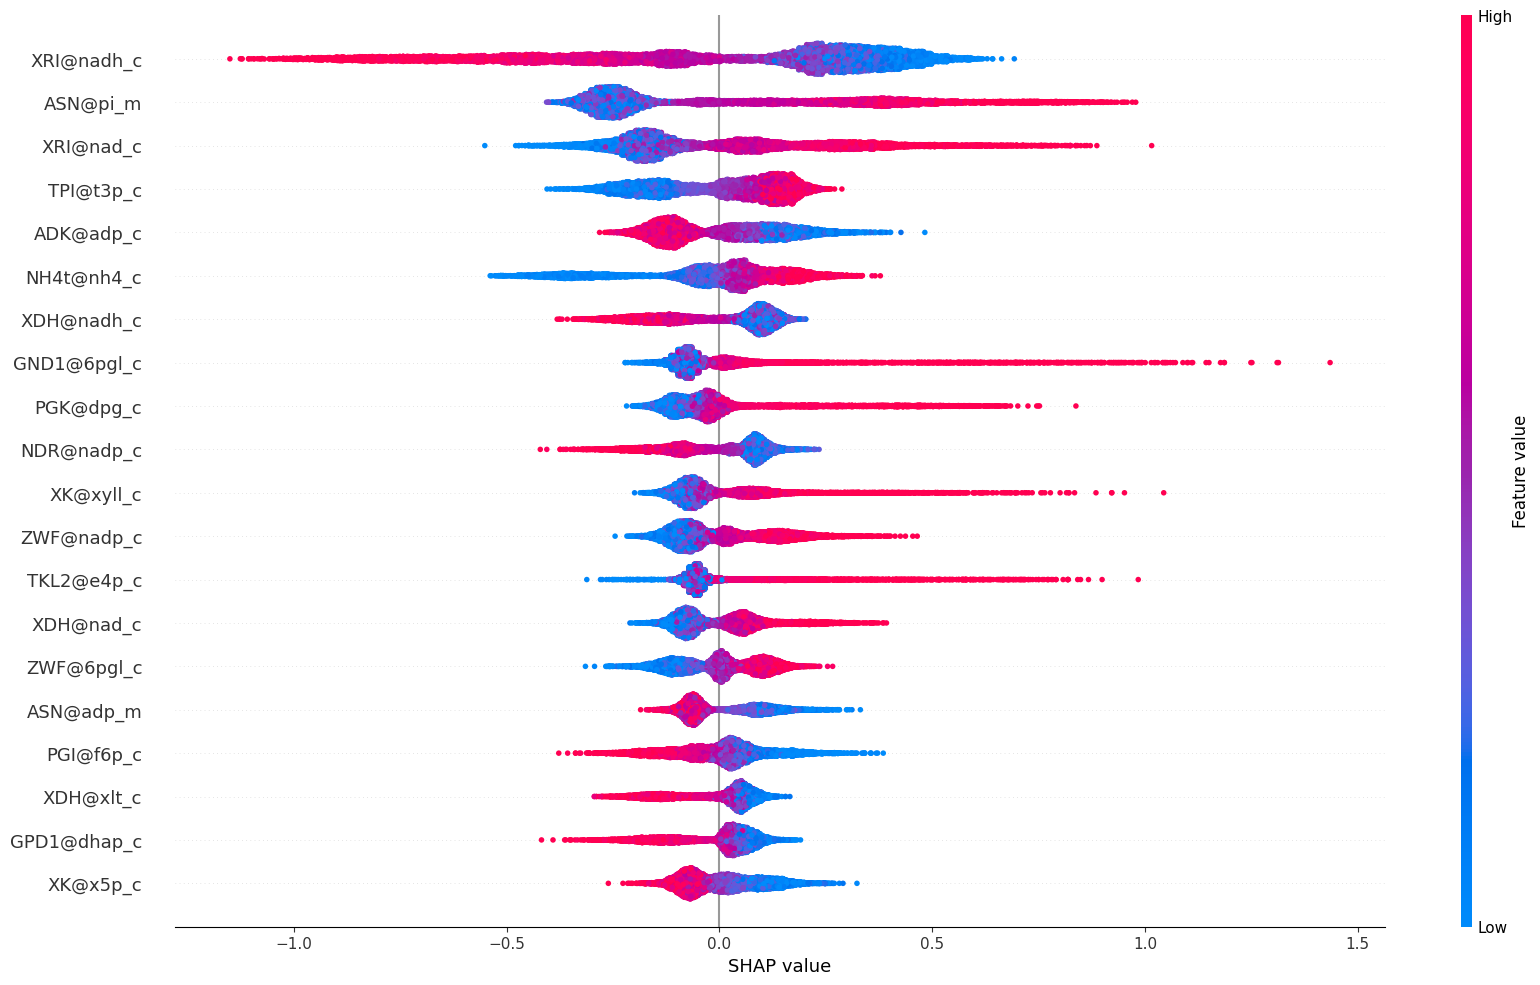

In [59]:
import shap

# Create a TreeExplainer for the xgb_model
explainer = shap.TreeExplainer(xgb_model)
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
# Display the SHAP summary plot

fig = plt.figure()
shap.summary_plot(shap_values, X_train, plot_type="dot", show=False)
plt.gcf().set_size_inches(20,10)
plt.xlabel("SHAP value")
plt.show()

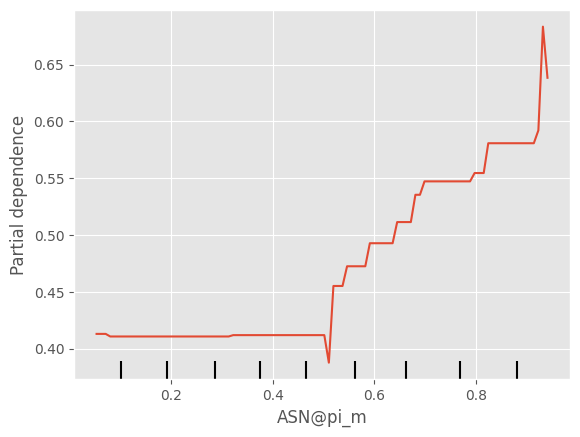

In [24]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(xgb_model, X_train, features=['ASN@pi_m'])
plt.show()